In [14]:
from utils.binaries import *
from utils.plotting import *

from scipy.optimize import curve_fit
from scipy.special import expit

/tmp/ipykernel_19673/3357780302.py:11: RuntimeWarning: overflow encountered in exp
  return A * np.exp(np.exp(mu*x)*x)
/home/filip/Public/phd-thesis/.phd-venv/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1017: RuntimeWarning: overflow encountered in square
  cost = np.sum(infodict['fvec'] ** 2)
/tmp/ipykernel_19673/3357780302.py:16: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(exp_exp, x[2:], inst_y)


Text(0.5, 0, '$I^\\mathrm{SSD}_\\mathrm{histo}$')

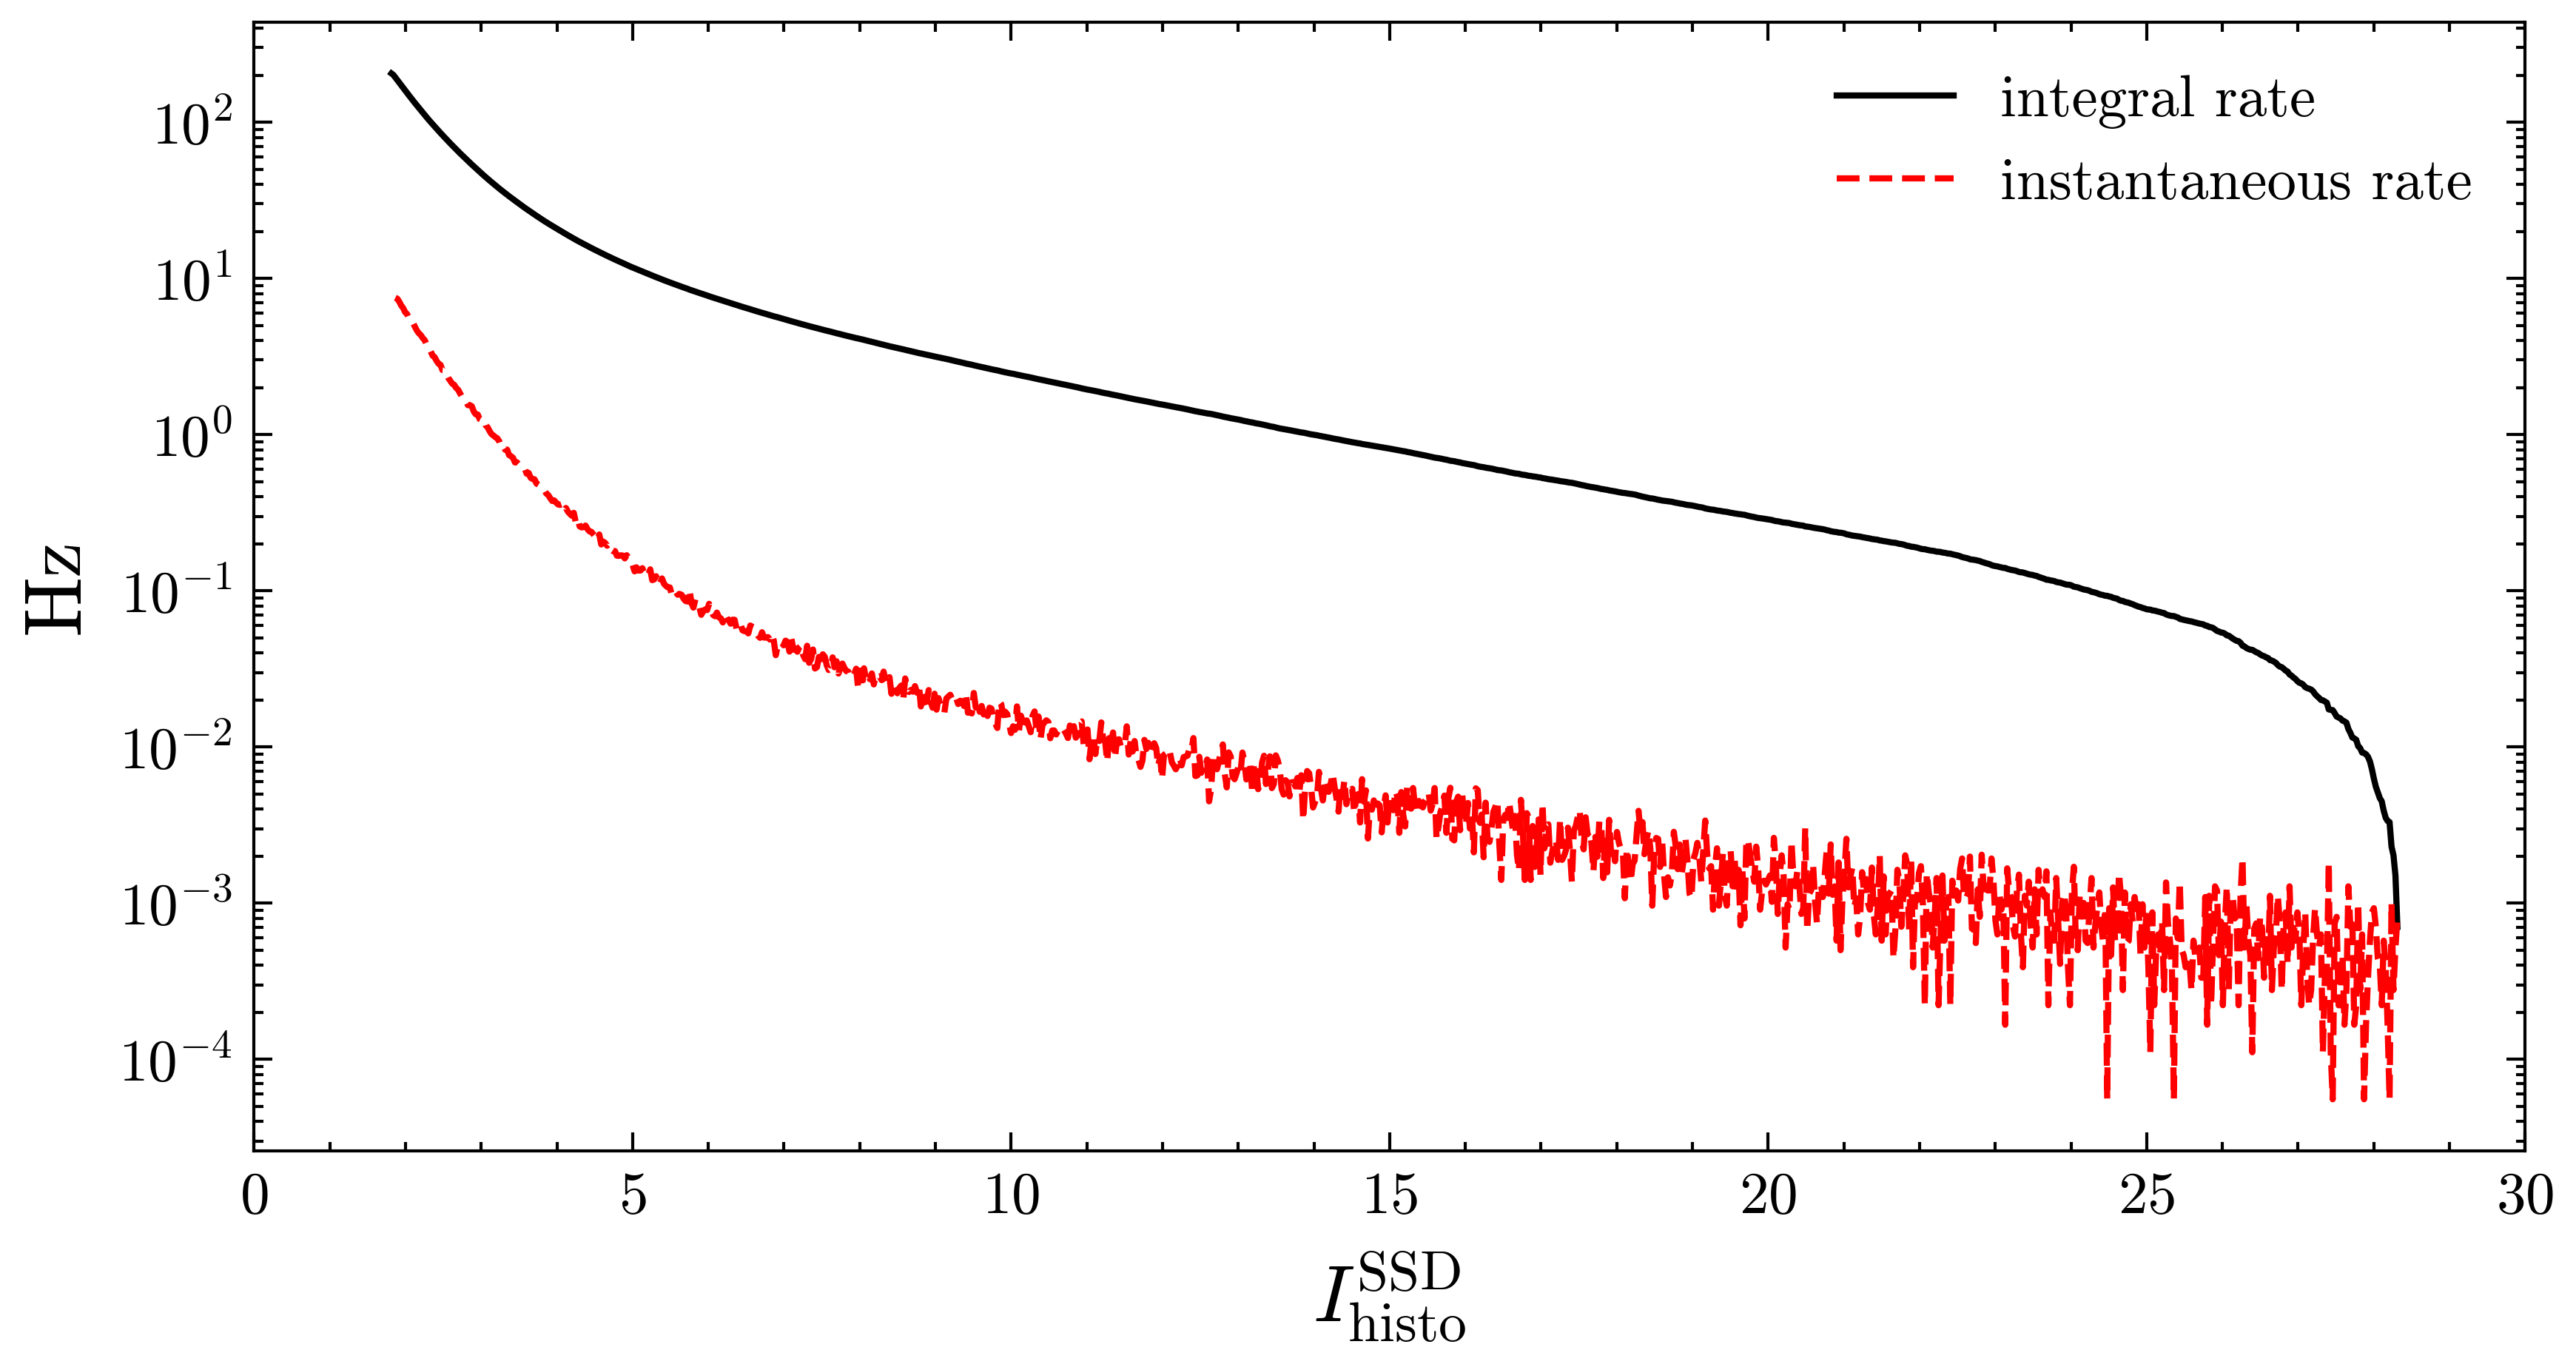

In [63]:
x, y = np.loadtxt('mean_rates_t3_mip.txt', unpack=True)
inst_y = -np.diff(y[1:])

def double_exp(x, cutoff, A1, mu1, A2, mu2):
    return A1 * np.exp(-mu1*x) * (1-expit(x-cutoff))  + A2 * np.exp(-mu2*x) * expit(x-cutoff)

def exp(x, A, mu):
    return A * np.exp(-mu*x)

def exp_exp(x, A, mu):
    return A * np.exp(np.exp(mu*x)*x)

# popt, pcov = curve_fit(double_exp, x[2:], inst_y,
#                        p0=[5, 0, 1.58947606, 1, 0.2])
# popt, pcov = curve_fit(exp, x[302:], inst_y[300:])
popt, pcov = curve_fit(exp_exp, x[2:], inst_y)

plt.plot(x, y, label='integral rate')
plt.plot(x[2:], inst_y, label='instantaneous rate', marker='none')
# plt.plot(x[2:], double_exp(x[2:], *popt), label='instantaneous fit', marker='none')
# plt.plot(x[2:], exp_exp(x[2:], *popt), label='instantaneous fit', marker='none')

plt.legend()
plt.xlim(0, 30)
plt.ylabel("Hz")
plt.yscale('log')
plt.xlabel("$I^\mathrm{SSD}_\mathrm{histo}$")

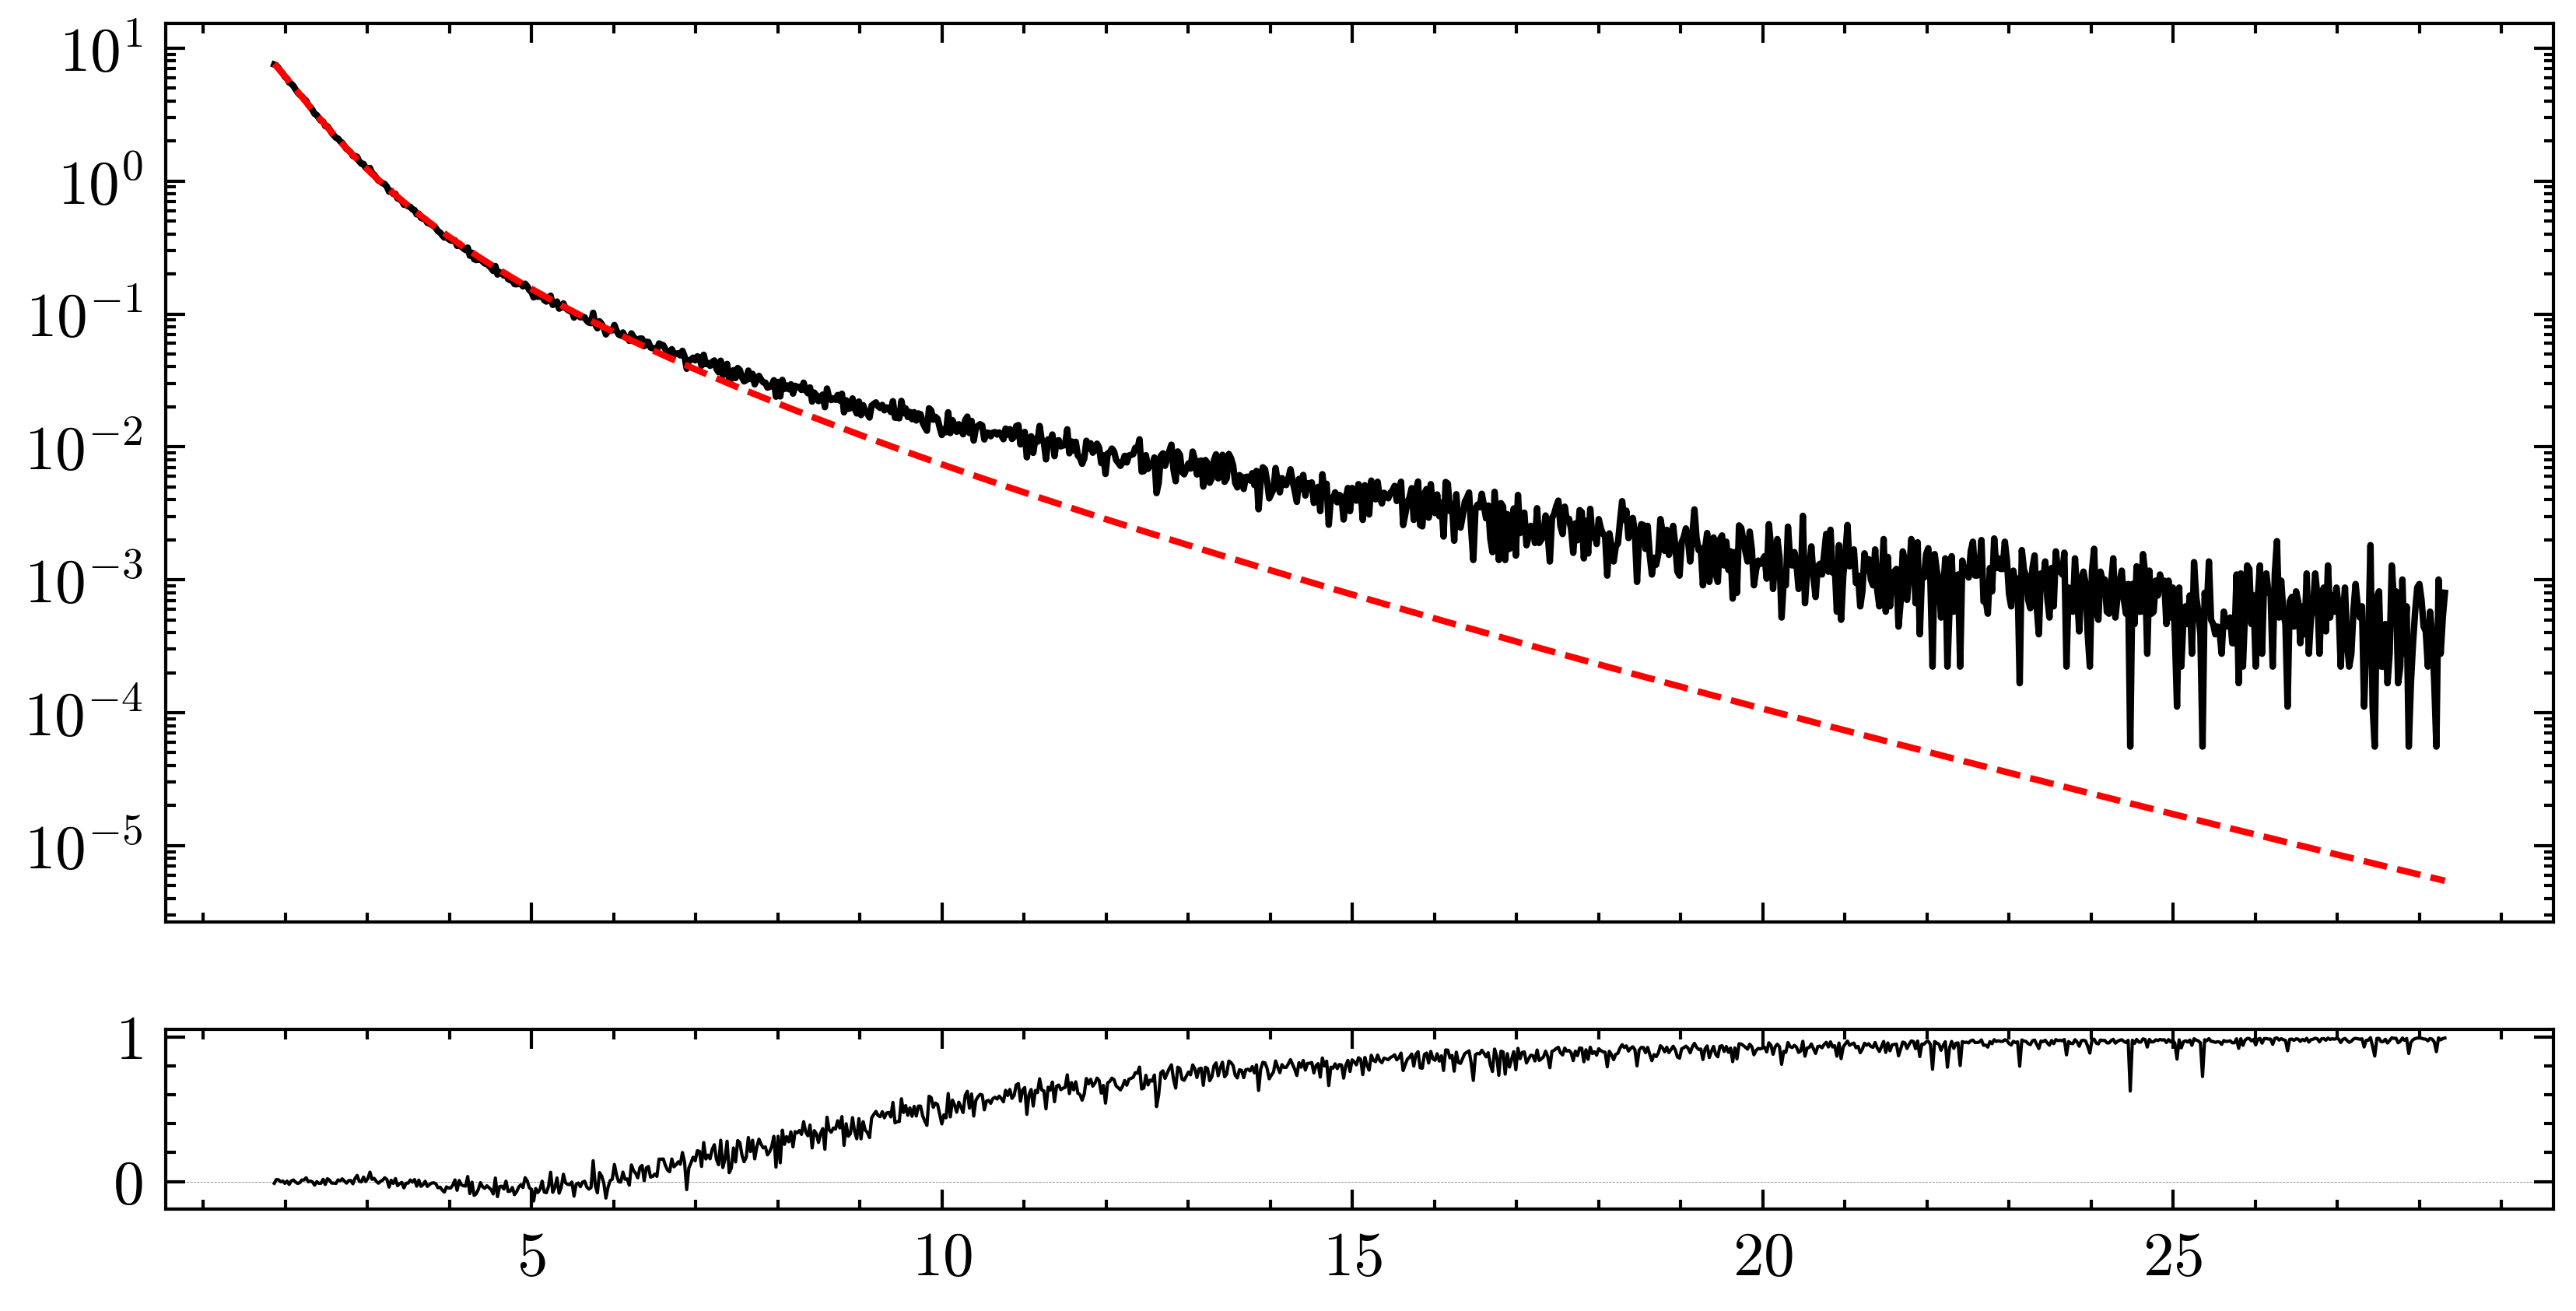

In [80]:
from scipy.stats import landau
from scipy.special import expit

def llandau(x, norm, loc, scale, suppression, cutoff):
    return norm * landau(loc, scale).pdf(x) * (1 - expit((x-cutoff)*suppression))

popt, pcov = curve_fit(llandau, x[2:], inst_y,
                       bounds=([0, 0, 0, 0, 0],[np.inf, np.inf, np.inf, np.inf, np.inf]),
                       p0=[31.88461781, 1.71248985, 0.34490904, 0., 0])


fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, height_ratios=[1,0.2])
ax1.plot(x[2:], inst_y, label='instantaneous rate', marker='none')
ax1.plot(x[2:], llandau(x[2:], *popt), marker='none')
ax1.set_yscale('log')

ax2.plot(x[2:], (inst_y - llandau(x[2:], *popt)) / inst_y, lw=0.5)
ax2.axhline(0, ls='--', lw=0.1, alpha=0.5)
# ax2.set_ylim(-10, 1)

In [75]:
print(popt)

[31.88461781  1.71248985  0.34490904  0.26711892]


In [51]:
# from data

t_cal = 10
t_70 = 50 / 48.94       # real world values
adjust = 0.2 / 48.94    # maybe this has an influence?
mip, rate = np.loadtxt('/cr/data01/filip/Data/muonAcquisition/mean_rates_t3_mip.txt', unpack=True)
i_ssd, inst_rate = mip[2:], -np.diff(rate[1:])

n_repeat = 5

while t_cal <= 60 or n_repeat:


    # create events
    peaks = np.array([])
    for x, y in zip(i_ssd, inst_rate):
        peaks = np.append(peaks, [x] * np.random.poisson(y * t_cal))
    
    # calculate trigger rate
    n_above = sum(peaks >= t_70)
    trigger_rate = n_above / t_cal
    sigma = np.sqrt(trigger_rate)
    delta = trigger_rate - 70

    match delta:
        case _ if np.abs(delta) < sigma:
            adjust -= 0.01 / 48.94
            t_cal += 5
        
        case _ if np.abs(delta) < 5:
            adjust = 0.1 / 48.94

        case _ if np.abs(delta) < 20:
            pass
        
        case _:
            adjust = 1.0 / 48.94
            t_cal = 10

    t_cal = min([61, np.max([10, t_cal])])
    adjust = min([1. / 48.94, np.max([0.01 / 48.94, t_cal])])

    if delta > 0: t_70 += adjust
    else:         t_70 -= adjust

    if t_cal >= 60: 
        n_repeat -= 1
        
        print(f"after {t_cal = } s, rate was {trigger_rate:.2f} Hz and threshold will be {t_70:.2f} (= {t_70/2.64-1:.2f})")

FileNotFoundError: /cr/data01/filip/Data/muonAcquisition/mean_rates_t3_mip.txt not found.